In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextGenerationPipeline, AdamW
import torch
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english", model_max_length=64)
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

# Try only updating final layers
params_to_update = []
for name,param in model.named_parameters():
    if 'classifier' in name:
        params_to_update.append(param)
        
optim = AdamW(params_to_update, lr=5e-5)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [3]:
sequence_0 = "I like you. I love you."

In [4]:
tokenizer.encode(sequence_0, return_tensors="pt")

tensor([[ 101, 1045, 2066, 2017, 1012, 1045, 2293, 2017, 1012,  102]])

In [5]:
model(tokenizer.encode(sequence_0, return_tensors="pt").to(device), 
      labels=torch.tensor([1]).unsqueeze(0).to(device))

SequenceClassifierOutput(loss=tensor(0.0001, device='cuda:0', grad_fn=<NllLossBackward>), logits=tensor([[-4.3136,  4.6843]], device='cuda:0', grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)

In [6]:
# model(tokenizer.encode(sequence_0, return_tensors="pt"), output_attentions=True).attentions[0].sum(axis=1)

In [7]:
# S = torch.nn.Softmax(dim=1)
# S(model(tokenizer.encode(sequence_0, return_tensors="pt")).logits.detach())

In [8]:
# model

In [9]:
def train_single(input_tensor_batch, target_tensor_batch, model, model_optimizer):
    '''
    A single forward and backward pass of the neural net on a single training batch.
    '''
    target_tensor = torch.stack(target_tensor_batch).reshape(len(input_tensor_batch))
    input_tensor = torch.stack(input_tensor_batch)
    input_tensor = input_tensor.reshape(len(input_tensor_batch), input_tensor.shape[2])
    output = model(input_tensor.to(device), 
                   labels = target_tensor.to(device),
                   output_attentions=False)
    loss = output[0]
    loss.backward()
    model_optimizer.step()
    return loss.item()

def train(input_tensors, target_tensors, input_val_tensors, target_val_tensors,
          model, model_optimizer, n_epochs):
    '''
    Train the attention classfier for a given number of epochs on the whole training set.
    '''
    losses = []
    train_accs = []
    val_accs = []
    # Iterate over given num of epochs
    for epoch in range(n_epochs):
        loss = 0
        # Iterate over batches
        for i in range(len(input_tensors)):
            input_tensor = input_tensors[i]
            target_tensor = target_tensors[i]
            loss += train_single(input_tensor, target_tensor, model, 
                                 model_optimizer)
        train_accuracy = get_accuracy(input_tensors, target_tensors, model)
        val_accuracy = get_accuracy(input_val_tensors, target_val_tensors, model)
        print(f"Epoch {epoch} :") 
        print(f"\tLoss {loss/len(input_tensors):.4f}")
        print(f"\tTraining Accuracy {train_accuracy:.4f}")
        print(f"\tValidation Accuracy {val_accuracy:.4f}")
        losses.append(loss/len(input_tensors))
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
    return losses, train_accs, val_accs

def get_accuracy(input_tensors, target_tensors, model):
    '''
    Get model accuracy.
    '''
    accs = []
    # Iterate over batches
    for i in range(len(input_tensors)):
        input_tensor_batch = input_tensors[i]
        target_tensor_batch = target_tensors[i]
        target_tensor = torch.stack(target_tensor_batch).reshape(len(input_tensor_batch)).to(device)
        input_tensor = torch.stack(input_tensor_batch)
        input_tensor = input_tensor.reshape(len(input_tensor_batch), input_tensor.shape[2]).to(device)
        output = model(input_tensor, output_attentions=False)
        # Get classification prediction
        preds = output.logits.argmax(axis=1)
        # Get accuracy of given batch
        batch_acc = ((preds == target_tensor).sum()/target_tensor.shape[0]).item()
        accs.append(batch_acc)
    return np.mean(accs)

def sent_pred(sent, model, tokenizer, device, batch_size):
    '''
    Runs the model on an input sentence.
    
    Arguments: 
    
      sent : str. The input sentence.
      model : the pytorch model to be used.
     
    Returns:
      pred : np array. The prediction, wich is a normalized array with a value for \
             each class, representing the predicted probability for that class
      attns : the attention matrix
    '''
    print(sent)
    input_tensor = tokenizer.encode(sent, return_tensors="pt").to(device)

    output = model(input_tensor, output_attentions=True)
    pred = output.logits.argmax(axis=1)
    
    softmax = torch.nn.Softmax(dim=1)
    scores = softmax(output.logits.detach())
    
    attns = output.attentions
    
    print(scores)
    return pred.detach().cpu().numpy(), scores, attns

In [10]:

# Stanford Politeness:
train_file = "../../../cross_style_transfer_internal/data/xslue/StanfordPoliteness/train.tsv"
dev_file = "../../../cross_style_transfer_internal/data/xslue/StanfordPoliteness/dev.tsv"
class_labels_dict = {0: "impolite", 1 : "polite"}




train_data = pd.read_csv(train_file, names=['domain', 'id', 'text', 'score'], sep='\t')
val_data = pd.read_csv(dev_file, names=['domain', 'id', 'text', 'score'], sep='\t')

In [11]:
def parse_stanford_politeness(polite_df):
    '''
    Parse stanford politeness dataframe into the format we need for classification.
    '''
    input_df = pd.DataFrame()
    input_df['text'] = polite_df['text']
    # Map scores >= 0 (polite) to label 1 and scores < 0 (impolite) to label 0.
    input_df['label'] = polite_df['score'].apply(lambda x : int(x >= 0))
    return input_df

def df_to_training_pairs(df, tokenizer, batch_size):
    input_tensors = df['text'].apply(lambda x : tokenizer.encode(x, 
                                                                 padding='max_length', 
                                                                 truncation=True, 
                                                                 return_tensors="pt"))
    target_tensors = df['label'].apply(lambda x : torch.LongTensor([x]))
    return input_tensors.values.reshape(-1, batch_size).tolist(), target_tensors.values.reshape(-1, batch_size).tolist()

In [12]:
train_df = parse_stanford_politeness(train_data)
val_df = parse_stanford_politeness(val_data)

In [13]:
batch_size = 32
input_tensors, target_tensors = df_to_training_pairs(train_df.head((len(train_df)//batch_size)*batch_size), 
                                                                   tokenizer, batch_size)
input_val_tensors, target_val_tensors = df_to_training_pairs(val_df.head((len(val_df)//batch_size)*batch_size), 
                                                                  tokenizer, batch_size)

In [15]:
train_epochs = 6
train(input_tensors, target_tensors, input_val_tensors, target_val_tensors, 
          model, optim, train_epochs)

Epoch 0 :
	Loss 0.8077
	Training Accuracy 0.5501
	Validation Accuracy 0.5605
Epoch 1 :
	Loss 0.9227
	Training Accuracy 0.5458
	Validation Accuracy 0.5566
Epoch 2 :
	Loss 0.8095
	Training Accuracy 0.5440
	Validation Accuracy 0.5605
Epoch 3 :
	Loss 0.7486
	Training Accuracy 0.5502
	Validation Accuracy 0.5605
Epoch 4 :
	Loss 0.8867
	Training Accuracy 0.6263
	Validation Accuracy 0.6074
Epoch 5 :
	Loss 0.8015
	Training Accuracy 0.6334
	Validation Accuracy 0.6230


([0.8076969743162007,
  0.9227098112369513,
  0.809513181835026,
  0.7486063410322388,
  0.8867387657428717,
  0.8015486587371145],
 [0.5501217532467533,
  0.5457589285714286,
  0.5440340909090909,
  0.5502232142857143,
  0.6263189935064936,
  0.6334212662337663],
 [0.560546875,
  0.556640625,
  0.560546875,
  0.560546875,
  0.607421875,
  0.623046875])

In [16]:
sent = "Open the door now!"

pred, scores, attns = sent_pred(sent, model, tokenizer, device, batch_size)

Open the door now!
tensor([[0.0520, 0.9480]], device='cuda:0')


In [17]:
attns[0].shape

torch.Size([1, 12, 7, 7])

In [18]:
# Sum over attention vectors for each head and handle dimensions and move to cpu
viz_attns = np.array([attn.sum(axis=1).cpu().detach().squeeze().numpy() for attn in attns])
# Sum over heads
viz_attns = viz_attns.sum(axis=0)
# Drop cls and sep tokens
viz_attns = viz_attns[0, 1:-1]

In [19]:
viz_attns.shape

(5,)

In [20]:
tokens = tokenizer.convert_ids_to_tokens(tokenizer.encode(sent))[1:-1]
scores = scores.cpu().detach().squeeze().numpy()

In [21]:
scores

array([0.05204312, 0.9479569 ], dtype=float32)

Tokenized Input: ['open', 'the', 'door', 'now', '!']
Style: polite
Class Scores: polite : 94.80%, impolite : 5.20%


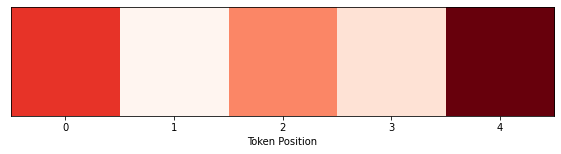

In [22]:
# Create heatmap
print(f"Tokenized Input: {tokens}")
print(f"Style: {class_labels_dict[pred[0]]}")
print(f"Class Scores: polite : {scores[1]*100:.2f}%, impolite : {scores[0]*100:.2f}%")
fig, ax = plt.subplots(figsize=(10, 2))
ax.get_yaxis().set_visible(False)
ax.set_xlabel("Token Position")
plt.imshow([viz_attns], cmap='Reds');
plt.savefig('Attention_impolite_heatmap.png')

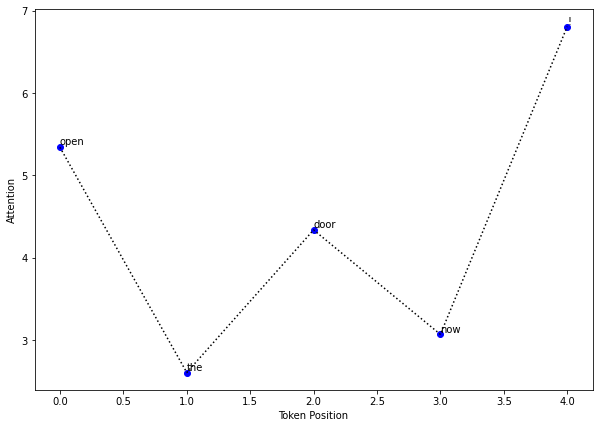

In [23]:
y = viz_attns
x = np.arange(len(tokens))
labels = tokens

fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(x, y, 'bo')
plt.plot(x, y, 'k:')
ax.set_ylabel("Attention")
ax.set_xlabel("Token Position")

for i, txt in enumerate(labels):
    ax.annotate(txt, (x[i], y[i]), xytext=(x[i] + 0.0, y[i] + 0.03))
plt.savefig('Attention_impolite_plot.png')

In [24]:
save_model = True
checkpoint_path = "../models/BERT"
if save_model:
    model.save_pretrained(checkpoint_path)